In [1]:
import pandas as pd
import numpy as np
import scipy.io
import re
import sys
import warnings
import pickle
from IPython.core.display import display, HTML, Markdown
from sklearn.svm import SVC
from mvpa2.measures.base import CrossValidation
from mvpa2.clfs.meta import NFoldPartitioner
from mvpa2.clfs.svm import LinearCSVMC
from mvpa2.datasets.mri import fmri_dataset
import mvpa2
from visualization import visualize_corr

from sklearn.calibration import CalibratedClassifierCV
from nilearn.masking import unmask
from mvpa_sst_utils import *

import sys
import os

sys.path.append(os.path.abspath("../../ml/"))

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import LeaveOneGroupOut

import math

from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

/tmp/ipykernel_23146/801465192.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown
Failed to import duecredit due to No module named 'duecredit'
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):
/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/visualization.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14

In [55]:
import nilearn.masking
import nilearn.image

In [2]:
from mvpa2.mappers.flatten import mask_mapper
import nibabel as nib

In [3]:
class BehavioralDataNotFoundForBrainDataException(Exception):
    """Behavioral data could not be matched to a subject."""
    pass

We use scikit-learn, implementing a forced-choice scorer. The aim of this notebook is to focus laser-sharp on outputting the content we want for the poster. We avoid content that isn't focused on this.

## Load

In [4]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [5]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [6]:
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]
exclude_subjects = ['DEV061','DEV185','DEV187','DEV189','DEV190','DEV192','DEV198','DEV203','DEV220','DEV221']
train_subjs = test_train_df.loc[test_train_df.SplitGroup=='Train','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [7]:
train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [8]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt_2022_02_26.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

We probably actually want to start the pipeline from the betas rather than loading from pickle. to be continued...

## new code

## whole brain

Now let's scale that up to the full dataset.

In [9]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl'

## masks

We get the same file this time, but we apply a mask before doing learning.

In [10]:
from generic_utils import *

In [11]:
## additional masks

all_masks = get_all_masks(ml_data_folderpath)

In [12]:
for mask_name in all_masks['mask_name']:
#    mask_value = all_masks[mask_name]
    print(mask_name,end=", ")

planning_association-test_z_FDR_0.01, executive function_association-test_z_FDR_0.01, response inhibition_association-test_z_FDR_0.01, inhibition_association-test_z_FDR_0.01, error_association-test_z_FDR_0.01, harvardoxford-cortical_prob_Frontal Orbital Cortex, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis, 

### try out one mask

In [13]:
brain_data_filepath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_harvardoxford-cortical_prob_Frontal Orbital Cortex.pkl"

#brain_data_filepath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_harvardoxford-cortical_prob_Insular Cortex.pkl"
#brain_data_filepath = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_response inhibition_association-test_z_FDR_0.01.pkl'

yikes, that does seem a bit too good. Particularly considering that the non-forced-choice rsults are also up really high. We shouldn't be seeing resutls this high! Let's see how it goes across all the masks I have chosen.

planning_association-test_z_FDR_0.01
2746.3888888888887


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6851851851851852 0.06172839506172839
executive function_association-test_z_FDR_0.01
95.46296296296296


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6111111111111112 0.09876543209876543
response inhibition_association-test_z_FDR_0.01
1881.9197530864199


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6975308641975309 0.9629629629629629
inhibition_association-test_z_FDR_0.01
635.574074074074


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6790123456790124 0.9382716049382716
error_association-test_z_FDR_0.01
402.7654320987654


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.6851851851851852 0.9259259259259259
harvardoxford-cortical_prob_Frontal Orbital Cortex
3024.91975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.691358024691358 0.9629629629629629
harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
2344.4506172839506


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.654320987654321 0.12345679012345678
harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
1943.0246913580247


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.691358024691358 0.7037037037037037


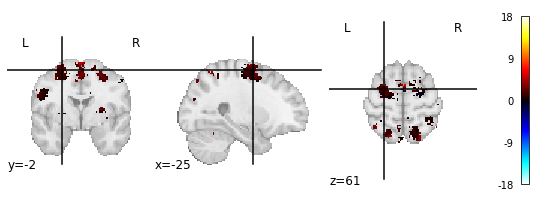

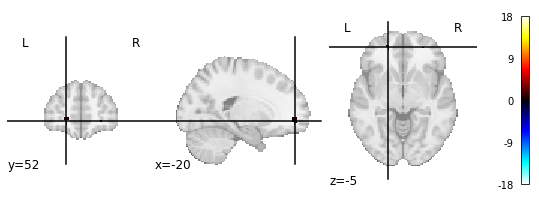

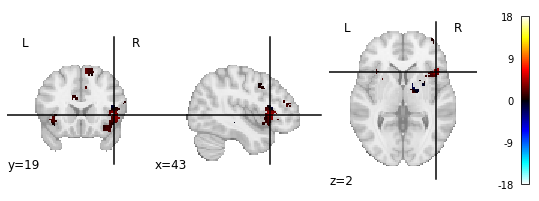

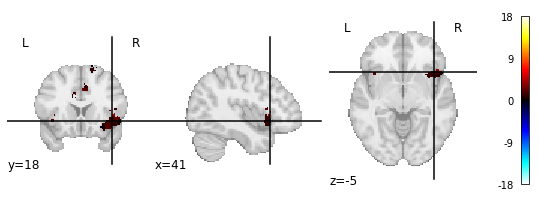

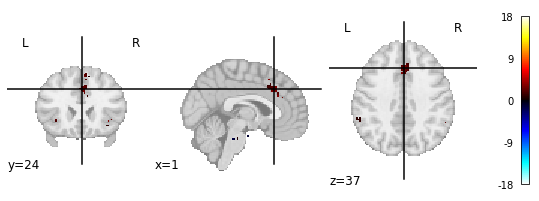

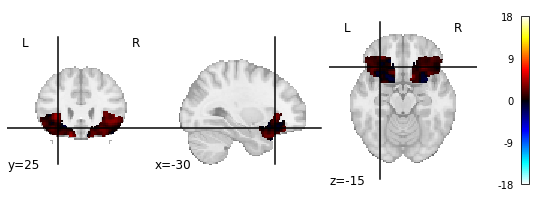

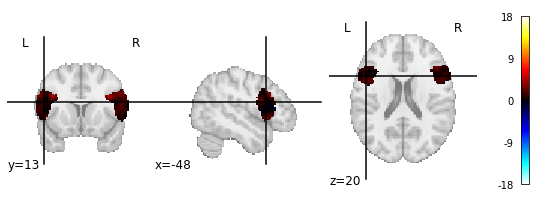

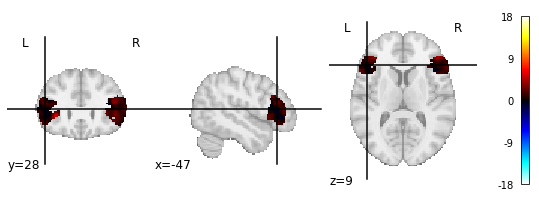

In [14]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)

        forced_choice_results = do_forced_choice(Brain_Data_allsubs)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        

Do we do an analysis with just the PFC and call it a day?

In [15]:

def do_LinearSVC(train_X,train_y,test_X,test_y):
    sklearn_clf = LinearSVC(penalty='l2', max_iter=1e4)
    #same as v3, my nilearn learner integrated with nltools
    #https://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html
    
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_clf.fit(train_X, train_y)

    #get the _probability_ we fall into each class
    #we'll use similarity/correlation here.
    predict_y_prob = pearson_img_series(test_X,sklearn_clf.coef_)#sklearn_clf.predict_proba(test_X)
    predict_y = sklearn_clf.predict(test_X)
    return(predict_y,predict_y_prob,sklearn_clf)


## Apply the main analysis, looping through masks

In [ ]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



print(prediction,forced_choice_prediction)

forced_choice_results_dict[mask_name]=forced_choice_results
# print_forced_choice_results(
#     forced_choice_results,
#     individual_differences,
#     ['ln_inv_pred_prob_CorrectStop'])

whole brain
124486.5
...................................

In [ ]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



print(prediction,forced_choice_prediction)

forced_choice_results_dict[mask_name]=forced_choice_results
# print_forced_choice_results(
#     forced_choice_results,
#     individual_differences,
#     ['ln_inv_pred_prob_CorrectStop'])

In [ ]:
print("whole brain, using obsolete incorrect timing file")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/archive/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



print(prediction,forced_choice_prediction)

forced_choice_results_dict[mask_name]=forced_choice_results
# print_forced_choice_results(
#     forced_choice_results,
#     individual_differences,
#     ['ln_inv_pred_prob_CorrectStop'])

## Contrast between CorrectStop and CorrectGo...

# v5 on PES

Here we're going to run the same "version 5" analysis as above, but on the PES contrast instead. Should be straightforward to replicate.


In [ ]:
pes_vars_of_interest  =['RTFS_factor_1','RTFS_factor_2','RTFS_f1_minus_f2', 'SST_PostErrorSlowW1_median','SST_PostErrorSlowW1_mean','SST_pes_mean_limited','FFQ_v2_Mean_Weighted_Nutrient_Density']


## discriminability

In [14]:
from generic_utils import *
## additional masks

all_masks = get_failure_masks(ml_data_folderpath)

### masked, conditions separate

In [15]:
all_masks

,mask_name,mask_filepath,thresh
0,negative affect_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
1,emotion regulation_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
2,harvardoxford-cortical_prob_Frontal Medial Cortex,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
3,negative emotions_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
4,self referential_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
5,harvardoxford-cortical_prob_Frontal Orbital Co...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0
6,"harvardoxford-cortical_prob_Cingulate Gyrus, a...",/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0


### trying to figure out the masking process

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_negative affect_association-test_z_FDR_0.01.pkl
negative affect_association-test_z_FDR_0.01
1170.0925925925926


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


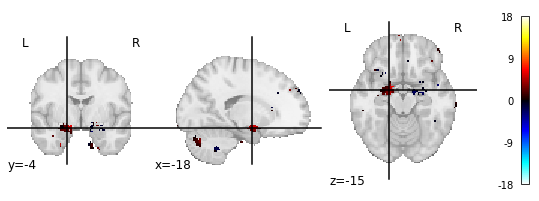

.................................................................................0.5185185185185185 0.6172839506172839


In [22]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_" +
        mask_name
        + ".pkl"
    )
    print(brain_data_filepath)
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)
        
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterCS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingCorrectStop'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterFS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingFailedStop'])

        print(prediction,forced_choice_prediction)
        
    break

#         forced_choice_results_dict[mask_name]=forced_choice_results

        
#         print_forced_choice_results(
#             forced_choice_results,
#             individual_differences,
#             ['ln_inv_pred_prob_CGAfterCS'],
#             behavioral_measures = pes_vars_of_interest,
#             target_y='CorrectGoFollowingCorrectStop')
#         print_forced_choice_results(
#             forced_choice_results,
#             individual_differences,
#             ['ln_inv_pred_prob_CGAfterFS'],
#             behavioral_measures = pes_vars_of_interest,
#             target_y='CorrectGoFollowingFailedStop')

In [24]:
classifier_object = forced_choice_results['classifier']
features = classifier_object.coef_

In [38]:
training_data = Brain_Data_allsubs.samples

sample_1_raw = training_data[0]

In [41]:
print(training_data.shape)
print(sample_1_raw.shape)

(162, 2279)
(2279,)


In [42]:
print(features.shape)

(1, 2279)

In [35]:
type(training_data[0])

numpy.ndarray

OK, so we can probably visualize the features the same way we visualize the training data? which is to say...

In [117]:
smoothing_mm = 2

training data (image 1):


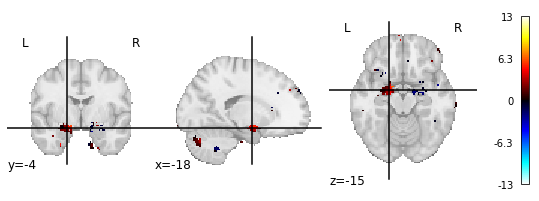

features:


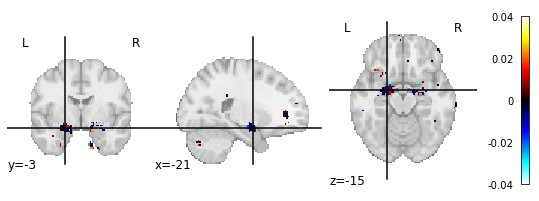

In [118]:
print("training data (image 1):")

sample_1_preview = unmask(sample_1_raw, Brain_Data_allsubs.a['mask_nifti'].value)
plotting.plot_stat_map(sample_1_preview)
plotting.show()

print("features:")
features_preview = unmask(features, Brain_Data_allsubs.a['mask_nifti'].value)
plotting.plot_stat_map(features_preview)
plotting.show()

In [119]:
mask_value=np.max(Brain_Data_allsubs.a['mask_nifti'].value.get_fdata())
print(mask_value)

1.0


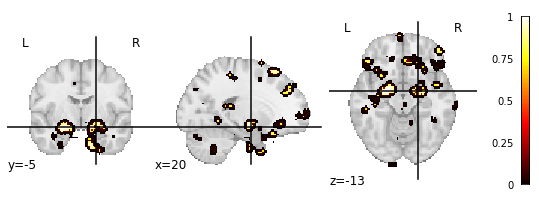

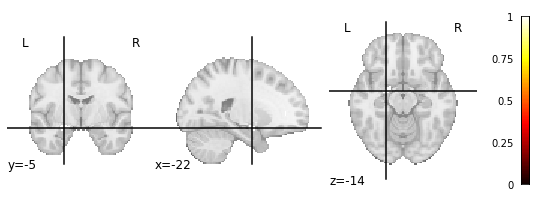

In [120]:
smoothed_mask = nilearn.image.smooth_img(Brain_Data_allsubs.a['mask_nifti'].value,smoothing_mm)
plotting.plot_stat_map(smoothed_mask)
plotting.show()
#now we wanna threshold that mask to only include items of the mask that are actually part of it.
smoothed_mask_thresholded =  nilearn.image.binarize_img(smoothed_mask, mask_value*0.99)

plotting.plot_stat_map(smoothed_mask_thresholded)
plotting.show()


Great, so now when we apply the mask to the smoothed features, we should apply this smoothed mask. That will cut out voxels on the edge of the mask whose value has been artifically reduced. This is not the best approach but it will ensure we don't show voxels, as if they're part of the image, with values artificially reduced by being "smoothed" with zero values outside the mask.

In [121]:
features_smoothed = nilearn.image.smooth_img(features_preview,smoothing_mm)
features_smoothed_masked = unmask(
    nilearn.masking.apply_mask(features_smoothed,smoothed_mask_thresholded),
    smoothed_mask_thresholded
        
    )

features masked:


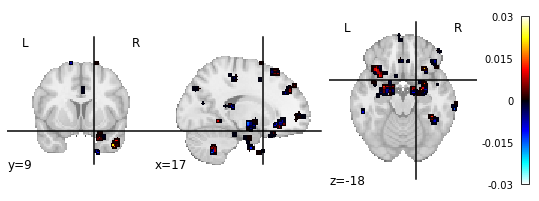

In [122]:
print("features masked:")
plotting.plot_stat_map(features_smoothed)
plotting.show()

features smoothed and masked:


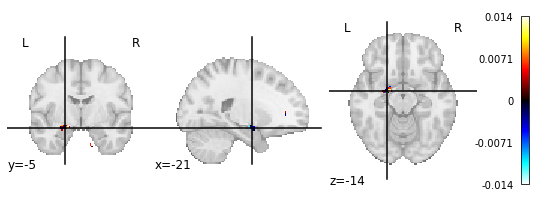

In [123]:
print("features smoothed and masked:")
plotting.plot_stat_map(features_smoothed_masked)
plotting.show()

features:


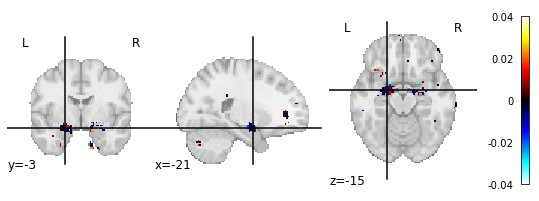

In [124]:
print("features:")
features_preview = unmask(features, Brain_Data_allsubs.a['mask_nifti'].value)
plotting.plot_stat_map(features_preview)
plotting.show()

In [134]:
type(features_preview)

nibabel.nifti1.Nifti1Image

In [137]:

def get_LinearSVC_coefs(classifier_object, mask_nifti, smoothing=None):
    assert(str(type(classifier_object))=="<class 'sklearn.svm._classes.LinearSVC'>")
    
    features_initial = unmask(features, mask_nifti)
    
    #we're going to apply smoothing. we need to smooth mask and the original image
    if smoothing is None:
        features_nifti = features_initial
    else:
        #smooth the mask
        smoothed_mask = nilearn.image.smooth_img(mask_nifti,smoothing)

        #now we wanna threshold that mask to only include items of the mask that are actually part of it.
        mask_value=np.max(mask_nifti.get_fdata())
        smoothed_mask_bin =  nilearn.image.binarize_img(smoothed_mask, mask_value*0.99)
        
        #now apply the ORIGINAL UNSMOOTHED mask
        features_smoothed = nilearn.image.smooth_img(features_initial,smoothing_mm)
        #then mask it according to the smoothed mask
        features_nifti = unmask(
            nilearn.masking.apply_mask(features_smoothed,smoothed_mask_bin),
            smoothed_mask_bin
            )
        
    return(features_nifti)
        

features_nifti_sm1 = get_LinearSVC_coefs(forced_choice_results['classifier'],
                   Brain_Data_allsubs.a['mask_nifti'].value,
                   2)

In [140]:
from nilearn.masking import compute_brain_mask, unmask

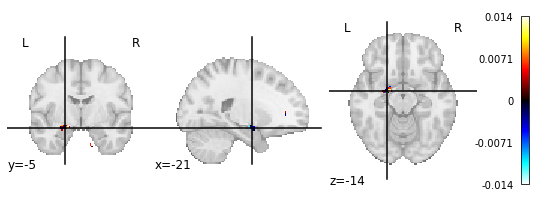

In [138]:
plotting.plot_stat_map(features_nifti_sm1)
plotting.show()

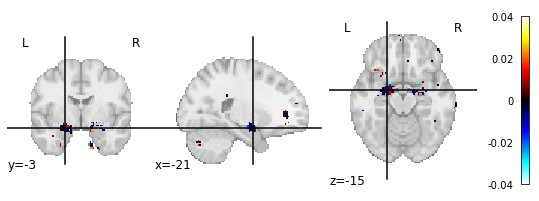

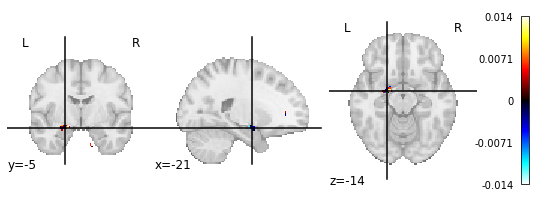

In [139]:
features_nifti = get_LinearSVC_coefs(forced_choice_results['classifier'],
                   Brain_Data_allsubs.a['mask_nifti'].value,
                   None)

plotting.plot_stat_map(features_nifti)
plotting.show()

features_nifti_sm2 = get_LinearSVC_coefs(forced_choice_results['classifier'],
                   Brain_Data_allsubs.a['mask_nifti'].value,
                   2)

plotting.plot_stat_map(features_nifti_sm2)
plotting.show()

Great! I think that works as intended.

We're going to save that new function in...visualization.py
...and one final thing. we need to save the output somewhere.

In [141]:
features_nifti_sm2.to_filename(ml_data_folderpath + '/nifti_test.nii.gz')

In [142]:
ml_data_folderpath

'/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml'